##### Copyright 2020 Qiyang Hu

In [0]:
#@title Licensed under MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/var/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Getting raw data

2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE ([source](https://github.com/CSSEGISandData/COVID-19))

In [1]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

--2020-03-19 17:49:47--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74283 (73K) [text/plain]
Saving to: ‘time_series_19-covid-Confirmed.csv’

time_series_19-covi 100%[===================>]  72.54K  --.-KB/s    in 0.02s   

2020-03-19 17:49:47 (3.40 MB/s) - ‘time_series_19-covid-Confirmed.csv’ saved [74283/74283]



In [0]:
import pandas as pd
import numpy as np

In [3]:
conf_df = pd.read_csv('time_series_19-covid-Confirmed.csv')
conf_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790


In [4]:
today = conf_df.columns[len(conf_df.columns)-1]
today

'3/18/20'

## Extracting US data

In [5]:
ts_us_list = conf_df[(conf_df['Country/Region'] == 'US')]
ts_us_list

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,267,366,442,568,572,643,904,1076,1014
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,220,328,421,525,732,967,1706,2495
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,177,221,282,340,426,557,698,751
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,95,108,123,138,164,197,218,218
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,36,42,42,44,44,44,45,45,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
414,Alabama,US,32.3182,-86.9023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,6,12,29,39,46
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,5,5,5
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,5


In [29]:
start_us = '3/4/20'
ts_us = ts_us_list.sum(axis = 0, skipna = True)[start_us:]
d_us = range(ts_us.count())
ts_us, d_us

(3/4/20      149
 3/5/20      217
 3/6/20      262
 3/7/20      402
 3/8/20      518
 3/9/20      583
 3/10/20     959
 3/11/20    1281
 3/12/20    1663
 3/13/20    2179
 3/14/20    2727
 3/15/20    3499
 3/16/20    4632
 3/17/20    6421
 3/18/20    7783
 dtype: object, range(0, 15))

## Extracting California data

In [28]:
ts_ca = conf_df[(conf_df['Province/State'] == 'California')]

start_ca = '3/10/20'

ts_ca = ts_ca.iloc[0][start_ca:]
d_ca = range(ts_ca.count())
ts_ca, d_ca

(3/10/20    144
 3/11/20    177
 3/12/20    221
 3/13/20    282
 3/14/20    340
 3/15/20    426
 3/16/20    557
 3/17/20    698
 3/18/20    751
 Name: 100, dtype: object, range(0, 9))

## Extracting Italy data

In [27]:
ts_it_list = conf_df[(conf_df['Country/Region'] == 'Italy')]

start_it = '2/23/20'

ts_it = ts_it_list.iloc[0][start_it:]
d_it = range(ts_it.count())
ts_it, d_it

(2/23/20      155
 2/24/20      229
 2/25/20      322
 2/26/20      453
 2/27/20      655
 2/28/20      888
 2/29/20     1128
 3/1/20      1694
 3/2/20      2036
 3/3/20      2502
 3/4/20      3089
 3/5/20      3858
 3/6/20      4636
 3/7/20      5883
 3/8/20      7375
 3/9/20      9172
 3/10/20    10149
 3/11/20    12462
 3/12/20    12462
 3/13/20    17660
 3/14/20    21157
 3/15/20    24747
 3/16/20    27980
 3/17/20    31506
 3/18/20    35713
 Name: 16, dtype: object, range(0, 25))

### Curve fitting Italy data as an inference trend

In [0]:
from scipy.optimize import curve_fit

We use exponential function with the consideration of no signs of flattening emergence.

In [0]:
def func(x, a, b, c):
  return a * np.exp(b * x) + c

In [22]:
popt, pcov = curve_fit(func, d_it, ts_it)
popt

array([ 1.17677531e+03,  1.45289470e-01, -1.56009244e+03])

## Extracting data for China (as reference)

In [0]:
ts_cn_list = conf_df[(conf_df['Country/Region'] == 'China')]
ts_cn = ts_cn_list.sum(axis = 0, skipna = True)['1/22/20':]
d_cn = range(ts_cn.count())
ts_cn, d_cn

## Plotting

In [0]:
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

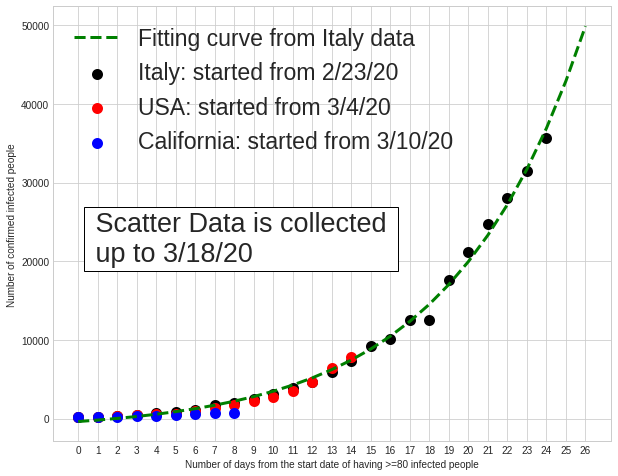

In [39]:
d_fn = range(ts_it.count()+2)

plt.figure(figsize=(10, 8))
plt.scatter(d_it, ts_it, color='black', linewidth=5, label='Italy: started from '+start_it)
plt.scatter(d_us, ts_us, color='red', linewidth=5, label='USA: started from '+start_us)
plt.scatter(d_ca, ts_ca, color='blue', linewidth=5, label='California: started from '+start_ca)
plt.plot(d_fn, func(d_fn, *popt), 'g--', linewidth=3, label="Fitting curve from Italy data")
#plt.scatter(d_cn, ts_cn, color='yellow', label='China: started from Jan 22')

plt.xticks(d_fn)
plt.xlabel("Number of days from the start date of having >=80 infected people")
plt.ylabel("Number of confirmed infected people")
plt.legend(loc='upper left', fontsize=23)
plt.text(0.5, 20000, ' Scatter Data is collected \n up to '+today+" ", fontsize=27, bbox=dict(facecolor='white', alpha=1))
plt.show()